In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression

In [3]:
def get_resampled_close(path: str, symbol: str = None, resample = "1d"):
    df = pd.read_csv(path)
    if symbol is None:
        symbol = df['symbol'][0]
    df['open_time'] = df['open_time'].apply(lambda x: 
                                    datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    df.set_index('open_time',inplace=True)
    df = df[['close']]
    df.rename(columns={'close':symbol},inplace=True)
    if resample is not None:
        df = df.resample(resample).last()
    df.ffill(inplace=True)
    return df.dropna()

In [25]:
path = "/Users/natalieng/Documents/AlgoTrading/Crypto_AlgoTrading/data/"
df1 = get_resampled_close(path + "ETHUSDT.csv")#,resample=None)
df2 = get_resampled_close(path + "pair_trade/XMRUSDT2020.csv",symbol="XMRUSDT")#,resample=None)
# df1 = get_resampled_close(path + "BTCUSDT.csv")#,resample=None)
# df2 = get_resampled_close(path + "pair_trade/DOTUSDT2021.csv",symbol="DOTUSDT")#,resample=None)
# df2 = get_resampled_close(path + "pair_trade/BCHUSDT2022.csv",symbol="BCHUSDT")#,resample=None)

In [33]:
data = pd.concat([df1, df2], axis=1)
data.columns = ['coin0','coin1']
data.dropna(axis=0, how='any',inplace=True)
data.tail()

,coin0,coin1
open_time,,
2020-12-26,628.51,168.05
2020-12-27,697.81,168.05
2020-12-28,729.40,166.44
2020-12-29,719.14,166.44
2020-12-30,734.05,159.70


/Users/natalieng/opt/anaconda3/envs/master/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


parameters: -66.1883148, 4.4653038


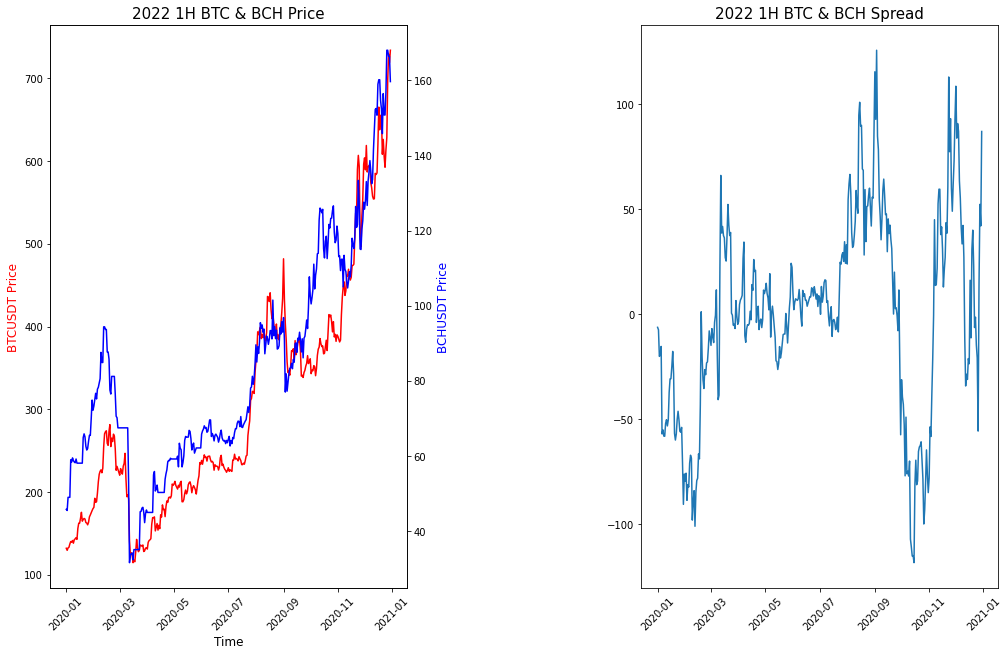

In [64]:
lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data['coin1'].values.reshape(-1,1), data['coin0'].values)        # fit() expects 2D array
print('parameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('2022 1H BTC & BCH Price',fontsize=15)
ax[0].plot(data.index,data.coin0,color="red")
ax[0].set_ylabel("BTCUSDT Price",color="red",fontsize=12)
ax[0].set_xlabel("Time",fontsize=12)
ax[0].tick_params(axis='x', labelrotation = 45)
ax2=ax[0].twinx()
ax2.plot(data.index,data.coin1,color="blue")
ax2.set_ylabel("BCHUSDT Price",color="blue",fontsize=12)
yfit = lm_model.coef_ * data['coin1'] + lm_model.intercept_
y_residual = data['coin0'] - yfit
ax[1].set_title('2022 1H BTC & BCH Spread',fontsize=15)
ax[1].plot(y_residual)
ax[1].tick_params(axis='x', labelrotation = 45)
fig.tight_layout()
fig.set_size_inches(16,12)
plt.show()